# Concrete Strength Model Tutorial
In this notebook, we show how to train and interact with the Gaussian process concrete strength model.

In [1]:
from typing import List

import botorch
import matplotlib.pyplot as plt
import pandas as pd
import torch

In [2]:
%matplotlib inline

## System Setup

NOTE: Modify the `path_to_repo` string to point to the location of the repository.


In [3]:
# Moving into the repository
import os

repo_name = "SustainableConcrete"
path_to_repo = "/Users/sebastianament/Code/"  # NOTE: enter the local path to the repository
repo_dir = path_to_repo + repo_name
if not os.getcwd()[-len(repo_name) :] == repo_name:
    os.chdir(repo_dir)
os.getcwd()

'/Users/sebastianament/Code/SustainableConcrete'

In [4]:
import sys
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

## Load Data
Assumption on data format:
- The "Mix ID" column contains entries of the format `<batch_name>_<mix_number>`, e.g. `Feb_2023_0` separates into a batch_name `Feb_2023` and a mix number `0`. Feel free to raise a GitHub issue if this format is restrictive for your use case.

In [5]:
data_path = "data/compressive_strength.csv"
df = pd.read_csv(data_path, delimiter=",")

In [6]:
import utils
import importlib
importlib.reload(utils)
from utils import get_mortar_bounds

data = utils.load_concrete_strength(
    data_path=data_path,
    verbose=False,  # turn on verbose if you want to understand the data processing
)
# optionally attach search space bounds to the data
data.bounds = get_mortar_bounds(data.X_columns)

In [7]:
data.X_columns  # model inputs

['Cement',
 'Fly Ash',
 'Slag',
 'Water',
 'HRWR',
 'Fine Aggregate',
 'Curing Temp (Cel.)',
 'Time']

In [8]:
X, Y, Yvar, X_bounds = data.strength_data  # strength data contains all time-dependent data

## Load Search Space Constraints

In [9]:
bounds = utils.get_mortar_bounds(X_columns=data.X_columns[:-1], verbose=True)  # exluding time 

The lower and upper bounds for the respective variables are set to:
	- Cement: [0.0, 950.0]
	- Fly Ash: [0.0, 950.0]
	- Slag: [0.0, 950.0]
	- Water: [35.0, 475.0]
	- HRWR: [0.0, 95.0]
	- Fine Aggregate: [925.0, 1775.0]
	- Curing Temp (Cel.): [0.0, 40.0]



In [10]:
equality_constraints, inequality_constraints = utils.get_mortar_constraints(
    X_columns=data.X_columns[:-1], 
    # binder_names=['Cement (kg/m3)', 'Fly Ash (kg/m3)', 'Slag (kg/m3)'],
    # aggregate_names=['Fine Aggregate (kg/m3)'],
    # water_name="Water (kg/m3)",
    verbose=True,
) # excluding time

Adding linear equality constraints:
	- Total Binder + Fine Aggregate : 1875.0
NOTE: the paste content constraint is proportional to the total mass, and the water and HRWR constraints are proportional to the total binder.



## Define and Fit Model
1. fit strength model
2. fit GWP model
3. unify as composition-input-only with fixed-time outputs

In [11]:
import models

In [12]:
model_strength_days = [1, 28]  # the strength days that are converted to optimization objectives
model = models.SustainableConcreteModel(strength_days=model_strength_days)

In [13]:
model.fit_gwp_model(data)

Bounds do not hold in training data: X_bounds[0, :], X.amin(dim=0) = (tensor([  0.,   0.,   0.,  35.,   0., 925.,   0.]), tensor([   0.0000,    0.0000,    0.0000,   43.0000,    0.0000, 1233.0000,
           4.5000], dtype=torch.float64))X_bounds[1, :], X.amax(dim=0) = (tensor([ 950.,  950.,  950.,  475.,   95., 1775.,   40.]), tensor([ 894.6700,  300.0000, 1198.6700,  443.0000,   13.3300, 2357.0000,
          22.0000], dtype=torch.float64))


SingleTaskGP(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): LogTransformedInterval(1.000E-04, 1.000E+00)
    )
  )
  (mean_module): ZeroMean()
  (covar_module): LinearKernel(
    (raw_variance_constraint): Positive()
  )
)

In [14]:
# use_fixed_noise=False because with only 3 measurements per sample,
# we can't trust the empirical variance completely. Instead, we infer
# the noise level using marginal likelihood optimization.
model.fit_strength_model(data, use_fixed_noise=False)

SingleTaskGP(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): LogTransformedInterval(1.000E-06, 1.000E+00)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): AdditiveKernel(
    (kernels): ModuleList(
      (0): ScaleKernel(
        (base_kernel): MaternKernel(
          (raw_lengthscale_constraint): LogTransformedInterval(1.000E-02, 1.000E+03)
        )
        (raw_outputscale_constraint): LogTransformedInterval(1.000E-02, 1.000E+02)
      )
      (1): ScaleKernel(
        (base_kernel): RBFKernel(
          (raw_lengthscale_constraint): LogTransformedInterval(1.000E-02, 1.000E+03)
        )
        (raw_outputscale_constraint): LogTransformedInterval(1.000E-02, 1.000E+02)
      )
    )
  )
  (outcome_transform): Standardize()
  (input_transform): ChainedInputTransform(
    (tf1): AffineInputTransform()
    (tf2): Log10()
    (tf3): Normalize()
  )
)

In [15]:
# converting the model to a list of models containing
# 1) the GWP model,
# 2) the 1-day "slice" of the strength model,
# 3) the 28-day "slice" of the strength model.
model_list = model.get_model_list()

## GWP Fit on Training Set

The GWP "observations" come from a linear model in the default dataset, so "predictions" of GWP are perfect. However, note that the methods allow for arbitrary, even a-priori non-predictable quantifications of sustainability.

Bounds do not hold in training data: X_bounds[0, :], X.amin(dim=0) = (tensor([  0.,   0.,   0.,  35.,   0., 925.,   0.]), tensor([   0.0000,    0.0000,    0.0000,   43.0000,    0.0000, 1233.0000,
           4.5000], dtype=torch.float64))X_bounds[1, :], X.amax(dim=0) = (tensor([ 950.,  950.,  950.,  475.,   95., 1775.,   40.]), tensor([ 894.6700,  300.0000, 1198.6700,  443.0000,   13.3300, 2357.0000,
          22.0000], dtype=torch.float64))


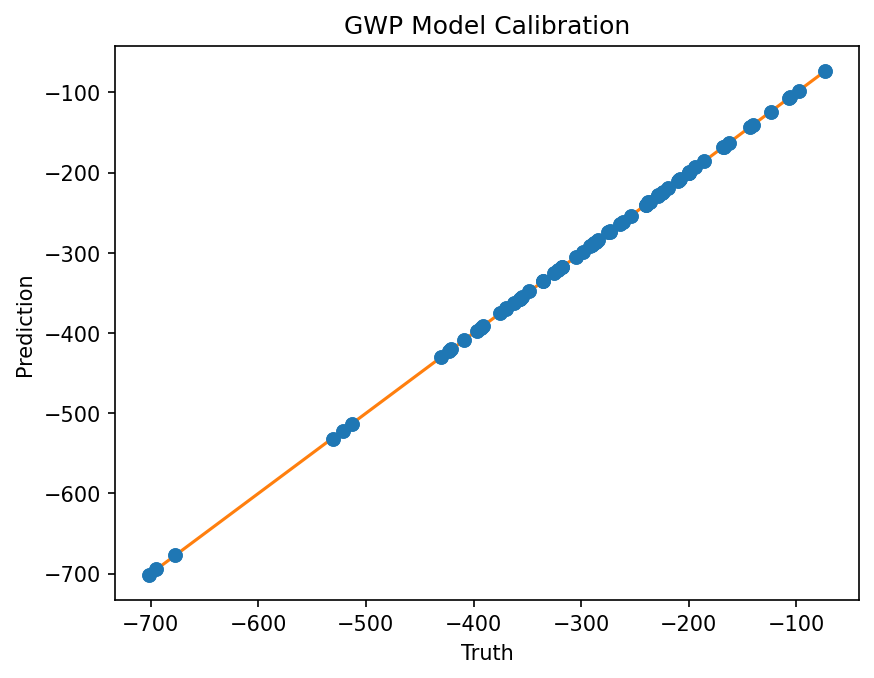

In [16]:
# NOTE: the original search space bounds are not satisfied by some of the original human-generated data.
X, Y, Yvar, X_bounds = data.gwp_data
ind = range(len(X))
post_list = model_list.posterior(X)

obj_id = 0
truth = Y[ind].detach()
pred = post_list.mean[:, 0].detach()
truth_std = Yvar[ind][ind].sqrt().detach()
pred_std = post_list.variance[:, obj_id].sqrt().detach()
plt.figure(dpi=150)
plt.title("GWP Model Calibration")
plt.ylabel("Prediction")
plt.xlabel("Truth")
plt.scatter(truth, pred)
plt.errorbar(truth, pred, yerr=2*pred_std, fmt="o")
line = torch.arange(truth.min(), truth.max())
plt.plot(line, line)
plt.show()

## Strength Fit on Training Set

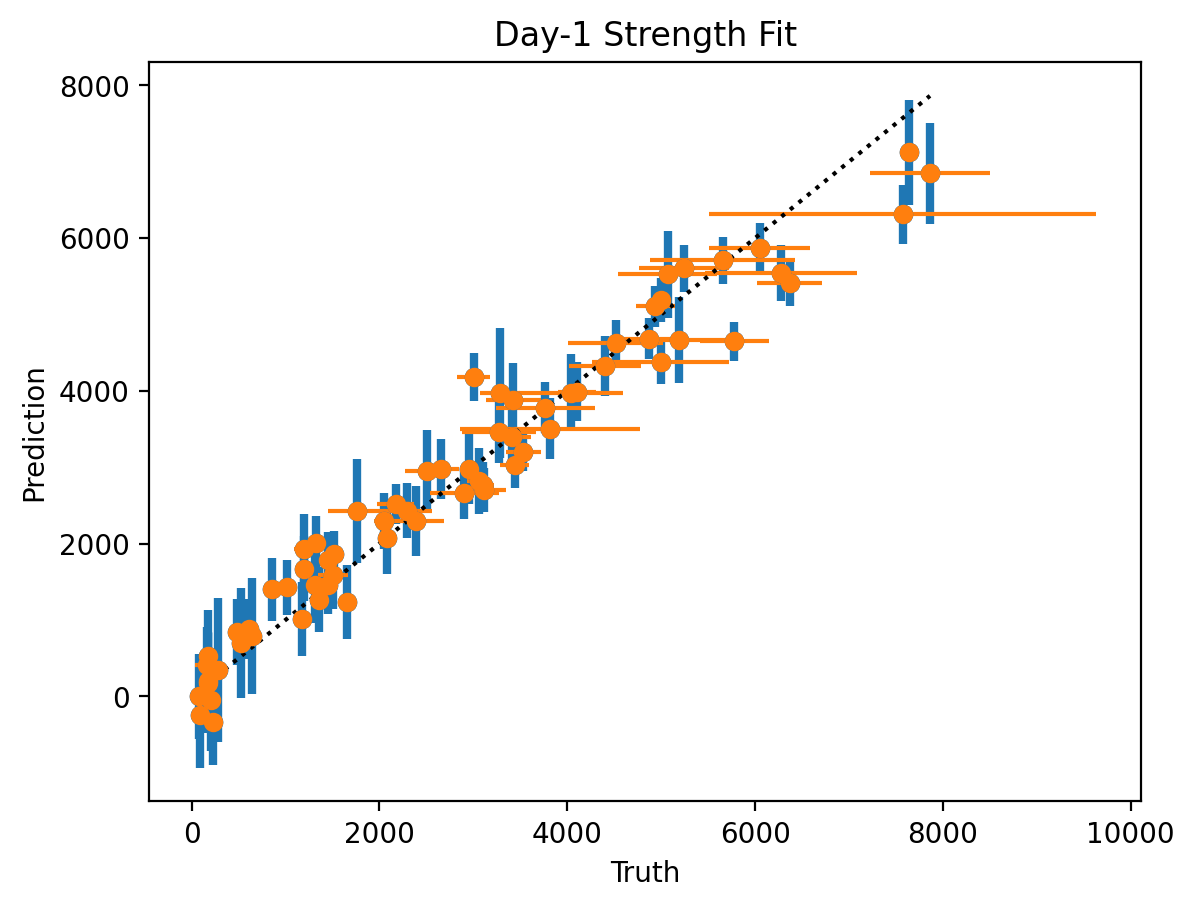

In [17]:
time = 1
Xt, truth, truth_var = data.strength_data_by_time(time)
truth = truth.squeeze(-1).detach()
truth_std = truth_var.sqrt().squeeze(-1).detach()

# 0 is GWP, 1 is 1 day, 2, is 28-day strength
post_t = model.strength_model.posterior(Xt)
pred = post_t.mean.squeeze(-1).detach()
pred_std = post_t.variance.sqrt().squeeze(-1).detach()

fig = plt.figure(dpi=200)
plt.title(f"Day-{time} Strength Fit")
plt.ylabel("Prediction")
plt.xlabel("Truth")
plt.scatter(truth, pred)
lw = 3
plt.errorbar(truth, pred, yerr=2 * pred_std, fmt="o", linewidth=lw)
plt.errorbar(truth, pred, xerr=2 * truth_std, fmt="o", linewidth=lw / 2)
line = torch.arange(truth.min(), truth.max())
plt.plot(line, line, color="black", linestyle=":")
plt.show()

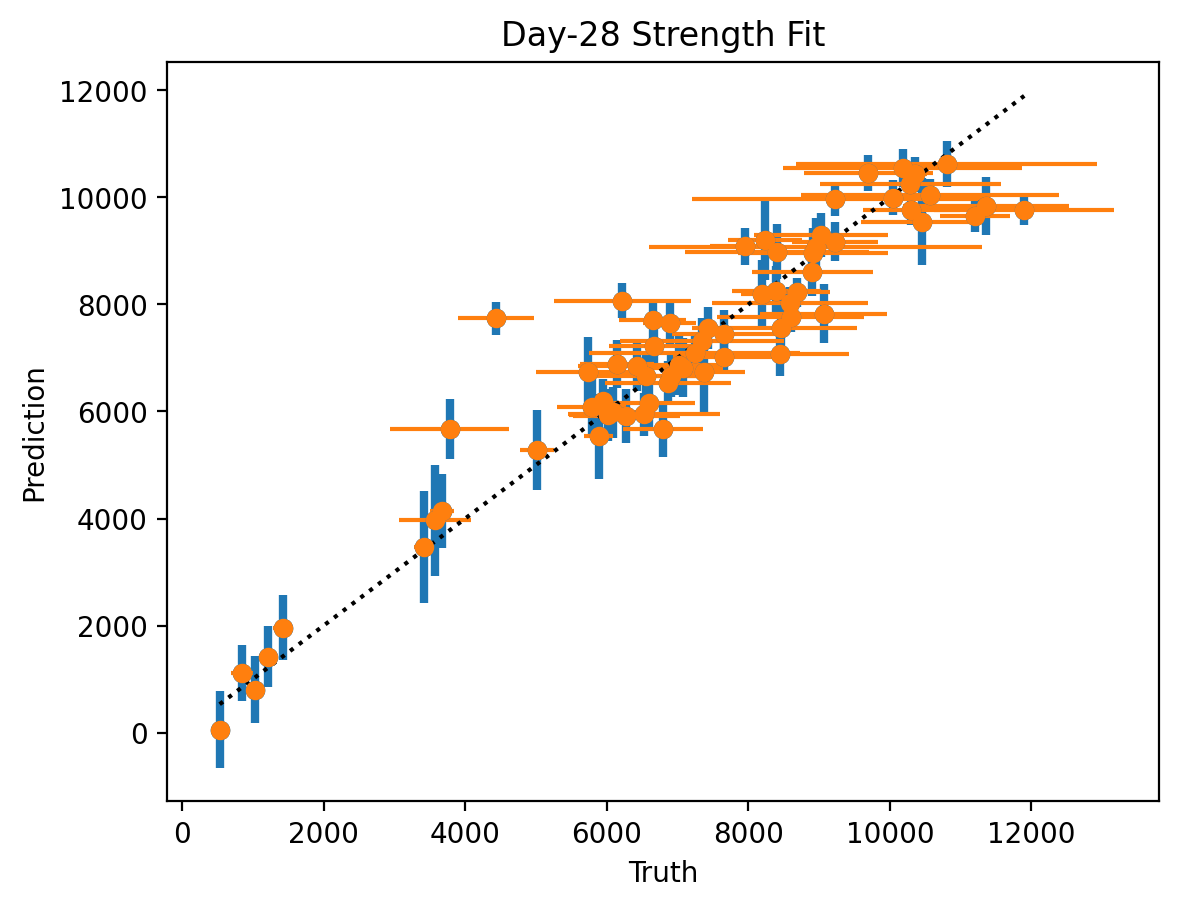

In [18]:
time = 28
Xt, truth, truth_var = data.strength_data_by_time(time)
truth = truth.squeeze(-1).detach()
truth_std = truth_var.sqrt().squeeze(-1).detach()

post_t = model.strength_model.posterior(Xt)
pred = post_t.mean.squeeze(-1).detach()
pred_std = post_t.variance.sqrt().squeeze(-1).detach()

fig = plt.figure(dpi=200)
plt.title(f"Day-{time} Strength Fit")
plt.ylabel("Prediction")
plt.xlabel("Truth")
plt.scatter(truth, pred)
lw = 3
plt.errorbar(truth, pred, yerr=2 * pred_std, fmt="o", linewidth=lw)
plt.errorbar(truth, pred, xerr=2 * truth_std, fmt="o", linewidth=lw / 2)
line = torch.arange(truth.min(), truth.max())
plt.plot(line, line, color="black", linestyle=":")
plt.show()

# Compute Predicted Pareto Frontier
For now, this is using a Polytope sampler to generate a random set of points satisfying the (adjusted) constraints and computing the Pareto frontier based on the predictive mean of the model. Future work: enable gradient-based optimization of the predicted Pareto frontier.

In [19]:
# this is the reference point for the Pareto frontier,
# representing the lower bounds on 1) -GWP, 2) 1-day, and
# 3) 28-day strength below which solutions become irrelevant.
ref_point = utils.get_reference_point()   
ref_point[0] = -400
ref_point

tensor([-400., 1000., 5000.], dtype=torch.float64)

In [20]:
import matplotlib 
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt 

tableau = list(mcolors.TABLEAU_COLORS.values())

# define bounds
all_bounds = utils.get_mortar_bounds(data.X_columns[:-1])
noash_bounds = all_bounds.clone()
all_bounds[1, 1] = 0.0  # no fly ash
noslag_bounds = all_bounds.clone()
noslag_bounds[1, 2] = 0.0  # no slag

# define a sequence of different constraints
wb_ratios = [0.25, 0.4, 0.25, 0.4, 0.25, 0.4]
bounds_list = [all_bounds, all_bounds, noash_bounds, noash_bounds, noslag_bounds, noslag_bounds]
names = ["all, w/b > 0.25", "all, w/b > 0.40", "no ash, w/b > 0.25", "no ash, w/b > 0.40", "no slag, w/b > 0.25", "no slag, w/b > 0.40"]
colors = [tableau[0], tableau[0], tableau[1], tableau[1], tableau[2], tableau[2]]
linestyles = ["-", ":", "-", ":", "-", ":"]

### Predicted GWP-1-day-strength trade-off

In [21]:
def get_inferred_pareto_frontiers(pareto_dims: List[int], num_candidates: int):
    X_all = []
    Y_all = []
    Ystd_all = []
    for bnds, min_wb, name in zip(bounds_list, wb_ratios, names):
        equality_constraints, inequality_constraints = utils.get_mortar_constraints(
            data.X_columns[:-1], min_wb=min_wb
        )
        X_pareto, Y_pareto, Ystd_pareto = utils.predict_pareto(
            model_list,
            pareto_dims=pareto_dims,
            ref_point=ref_point,
            bounds=bnds,
            equality_constraints=equality_constraints,
            inequality_constraints=inequality_constraints,
            num_candidates=num_candidates,
        )
        X_all.append(X_pareto.detach().numpy())
        Y_all.append(Y_pareto.detach().numpy())
        Ystd_all.append(Ystd_pareto.detach().numpy())
    return Y_all, Ystd_all

In [22]:
predicted_pareto_results = []
for strength_dim in [1, 2]:
    pareto_dims = [
        0,
        strength_dim,
    ]  # change second dimension to compute either 1-day or 28-day plot
    predicted_pareto_results.append(
        get_inferred_pareto_frontiers(
            pareto_dims,
            # number of random composition candidates from which to pick the Pareto-optimal ones.
            # increasing this number gives a more accurate estimate of the Pareto frontier.
            num_candidates=16_000,  
        )
    )

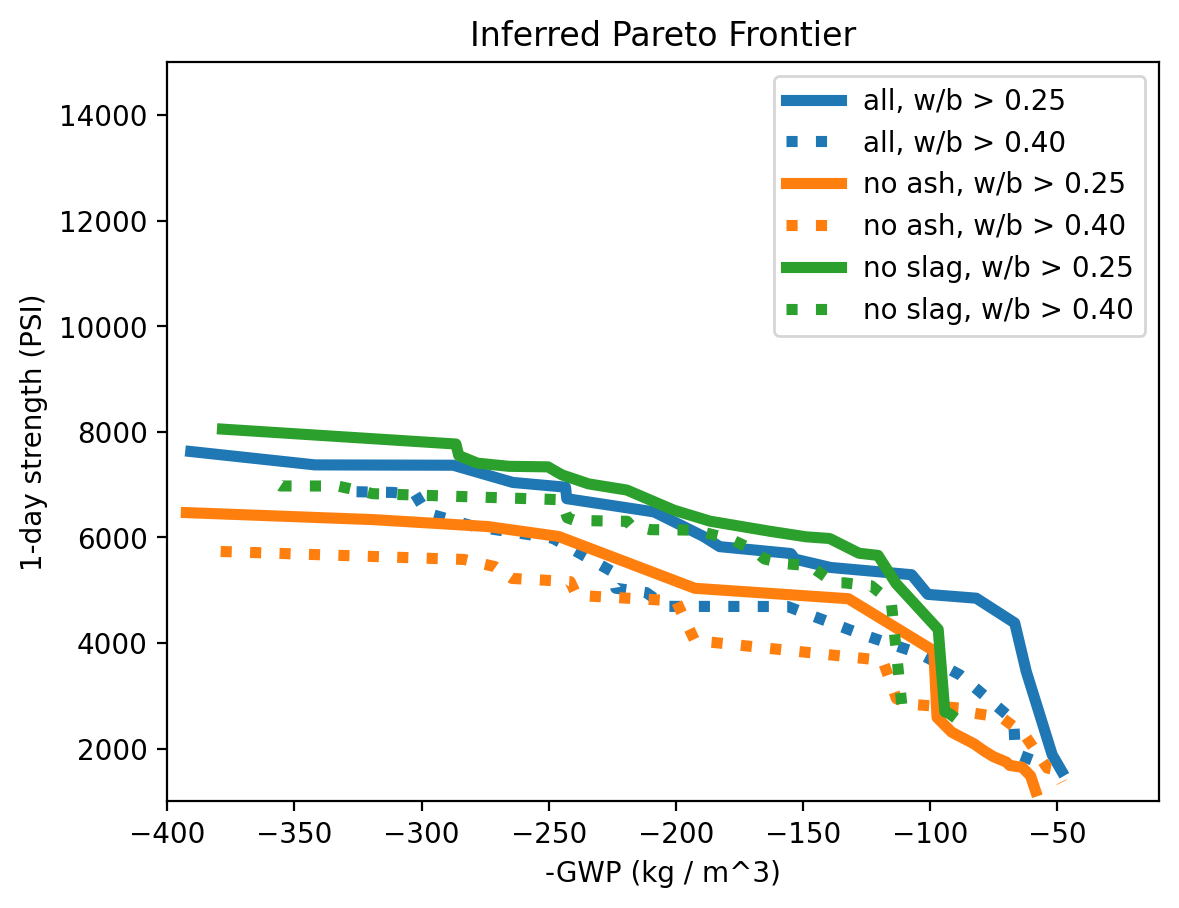

In [23]:
fig = plt.figure(dpi=200)
plt.title("Inferred Pareto Frontier")
plt.ylabel("1-day strength (PSI)")
plt.xlabel("-GWP (kg / m^3)")
Y_all, Ystd_all = predicted_pareto_results[0]
for Y, Ystd, name, ls, color in zip(Y_all, Ystd_all, names, linestyles, colors):
    plt.plot(Y[:, 0], Y[:, 1], label=name, linestyle=ls, color=color, lw=4)
    # can also plot predictive uncertainties, but this gets messy
    # plt.fill_between(Y[:, 0], Y[:, 1] + Ystd[:, 1], Y[:, 1] - Ystd[:, 1], alpha=.5, color=color)

lower_gwp_bound = ref_point[0]
xlim = (lower_gwp_bound, -10)
ylim = (1000, 15000)
plt.xlim(xlim)
plt.ylim(ylim)
plt.legend()
plt.show()

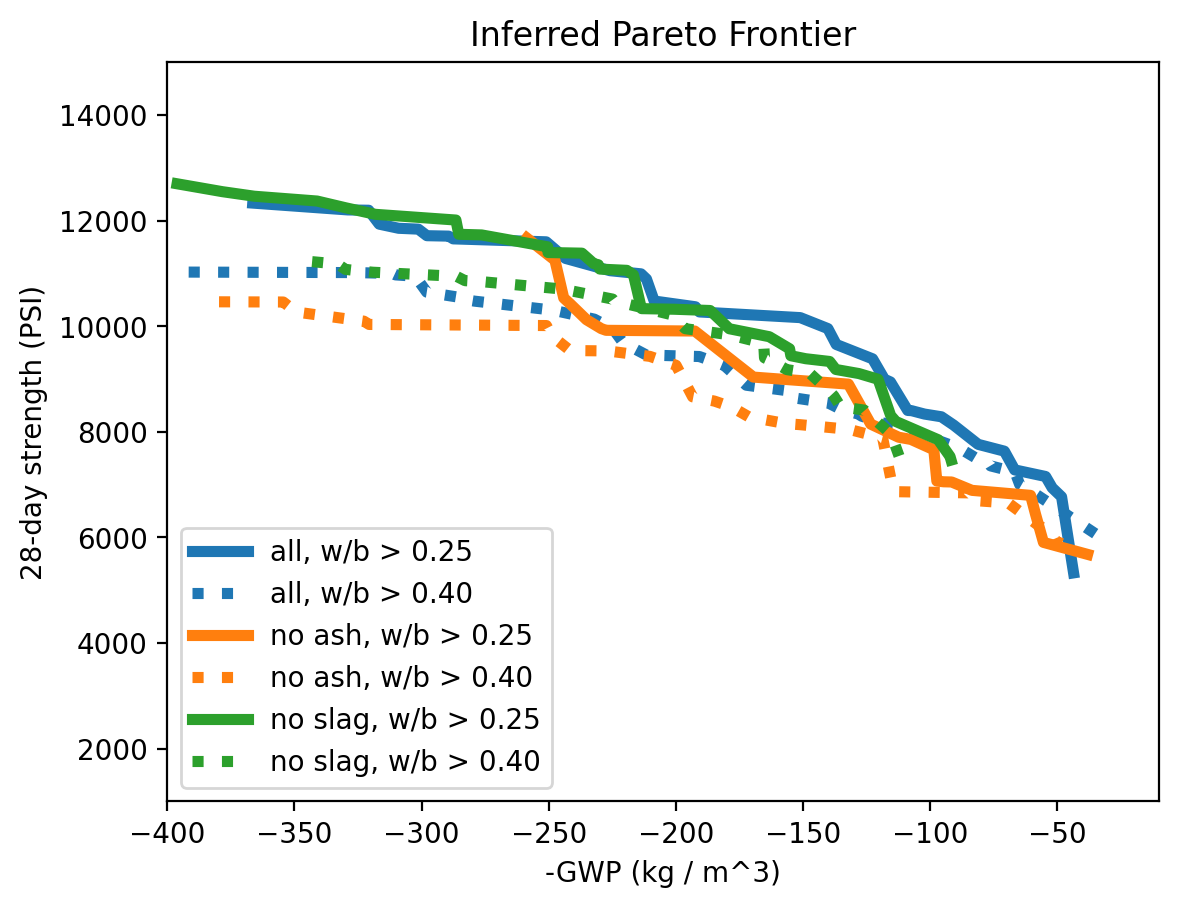

In [24]:
fig = plt.figure(dpi=200)
plt.title("Inferred Pareto Frontier")
plt.ylabel("28-day strength (PSI)")
plt.xlabel("-GWP (kg / m^3)")
Y_all, Ystd_all = predicted_pareto_results[1]
for Y, Ystd, name, ls, color in zip(Y_all, Ystd_all, names, linestyles, colors):
    plt.plot(Y[:, 0], Y[:, 1], label=name, linestyle=ls, color=color, lw=4)
    # plt.fill_between(Y[:, 0], Y[:, 1] + Ystd[:, 1], Y[:, 1] - Ystd[:, 1], alpha=.5, color=color)

xlim = (lower_gwp_bound, -10)
ylim = (1000, 15000)
plt.xlim(xlim)
plt.ylim(ylim)
plt.legend()
plt.show()